In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix


In [2]:
train_dir = r"C:\Users\abhilash\OneDrive\Desktop\Project2 - Copy - Copy\skin-disease-datasaet\train_set"
test_dir = r"C:\Users\abhilash\OneDrive\Desktop\Project2 - Copy - Copy\skin-disease-datasaet\test_set"
IMG_SIZE = (224, 224)
BATCH_SIZE = 32


In [3]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

class_names = list(train_generator.class_indices.keys())
print("Classes:", class_names)


Found 1048 images belonging to 9 classes.
Found 258 images belonging to 9 classes.
Classes: ['BA- cellulitis', 'BA-impetigo', 'FU-athlete-foot', 'FU-nail-fungus', 'FU-ringworm', 'PA-cutaneous-larva-migrans', 'VI-chickenpox', 'VI-shingles', 'unknown']


In [4]:
base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze base model for transfer learning


9406464/9406464 [==============================] - 2s 0us/step


In [5]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.5)(x)
predictions = Dense(len(class_names), activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                             

In [6]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.5)(x)
predictions = Dense(len(class_names), activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                           

In [7]:
EPOCHS = 15

early_stop = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)
checkpoint = ModelCheckpoint("mobilenet_skin_model.h5", monitor='val_accuracy', save_best_only=True)

history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=test_generator,
    callbacks=[early_stop, checkpoint]
)


Epoch 1/15
33/33 [==============================] - 43s 1s/step - loss: 1.6109 - accuracy: 0.4532 - val_loss: 0.7028 - val_accuracy: 0.7791
Epoch 2/15
33/33 [==============================] - 36s 1s/step - loss: 0.8274 - accuracy: 0.7347 - val_loss: 0.4223 - val_accuracy: 0.8837
Epoch 3/15
33/33 [==============================] - 35s 1s/step - loss: 0.6215 - accuracy: 0.7996 - val_loss: 0.3264 - val_accuracy: 0.9031
Epoch 4/15
33/33 [==============================] - 35s 1s/step - loss: 0.4783 - accuracy: 0.8302 - val_loss: 0.2792 - val_accuracy: 0.9109
Epoch 5/15
33/33 [==============================] - 35s 1s/step - loss: 0.4228 - accuracy: 0.8626 - val_loss: 0.2626 - val_accuracy: 0.9147
Epoch 6/15
33/33 [==============================] - 35s 1s/step - loss: 0.4049 - accuracy: 0.8769 - val_loss: 0.2332 - val_accuracy: 0.9341
Epoch 7/15
33/33 [==============================] - 35s 1s/step - loss: 0.3471 - accuracy: 0.8855 - val_loss: 0.2613 - val_accuracy: 0.9186
Epoch 8/15
33/33 [==

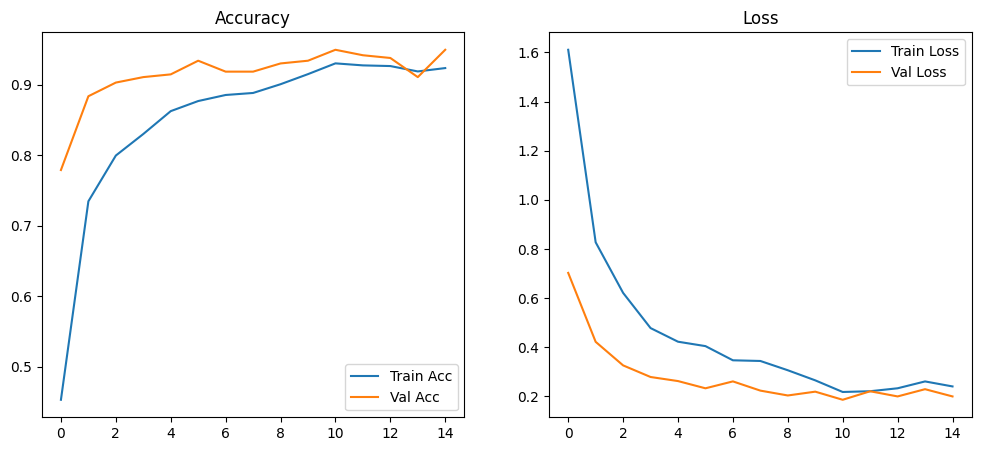

In [8]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label="Train Acc")
plt.plot(history.history['val_accuracy'], label="Val Acc")
plt.title("Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label="Train Loss")
plt.plot(history.history['val_loss'], label="Val Loss")
plt.title("Loss")
plt.legend()
plt.show()


9/9 [==============================] - 8s 758ms/step
                            precision    recall  f1-score   support

            BA- cellulitis       0.92      1.00      0.96        33
               BA-impetigo       0.95      1.00      0.98        20
           FU-athlete-foot       0.91      1.00      0.96        32
            FU-nail-fungus       0.97      0.94      0.95        33
               FU-ringworm       1.00      0.83      0.90        23
PA-cutaneous-larva-migrans       0.95      0.84      0.89        25
             VI-chickenpox       1.00      1.00      1.00        34
               VI-shingles       0.88      0.91      0.90        33
                   unknown       1.00      1.00      1.00        25

                  accuracy                           0.95       258
                 macro avg       0.95      0.95      0.95       258
              weighted avg       0.95      0.95      0.95       258



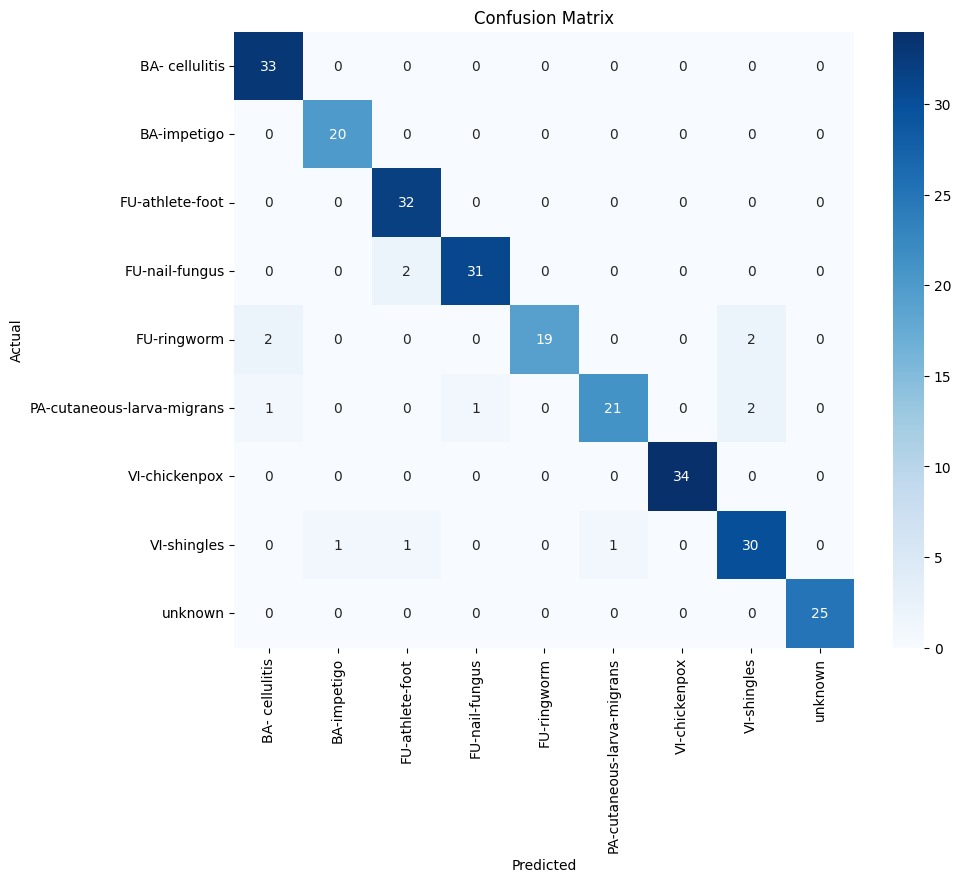

In [9]:
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
y_true = test_generator.classes

print(classification_report(y_true, y_pred, target_names=class_names))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [10]:
model.save("mobilenet_skin_model.h5")
